In [132]:
import casadi as ca
from dynamics_hybrid import f
import numpy as np
import matplotlib.pyplot as plt

Tracking OCP: Which controls are necessary to make the angle between the rods vary sinusoidally?

Impact at t=0.100s — velocities updated


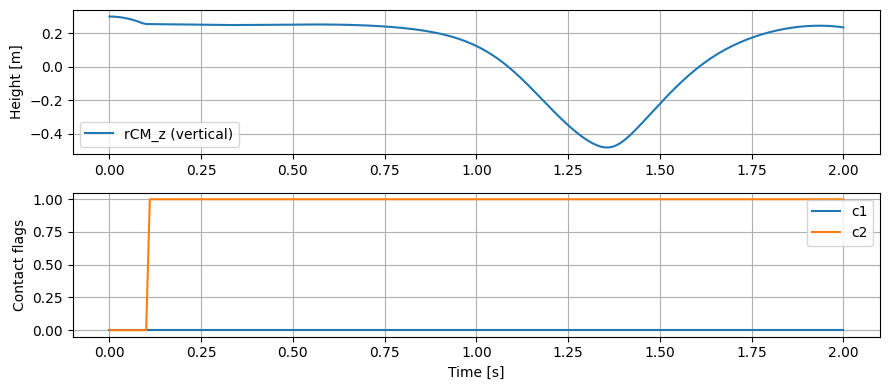

In [133]:
# ----------------------------
# Simulation setup
# ----------------------------
tf = 2.0          # total time [s]
N  = 200          # number of integration steps
dt = tf / N
ts = np.linspace(0, tf, N+1)

# ----------------------------
# Load your full dynamics function
# ----------------------------
# Make sure fdyn_total is imported from your CasADi file or module
# e.g.  from dynamics_hybrid import fdyn_total
f = f.expand()

# Extract symbolic inputs and outputs
x, u, p, c1, c2 = f.mx_in()
dxdt, lam_out, c1_new, c2_new, dq_plus = f(x, u, p, c1, c2)

# Wrap into callable function
Fdyn = ca.Function('Fdyn',
                   [x, u, p, c1, c2],
                   [dxdt, lam_out, c1_new, c2_new, dq_plus],
                   ['x','u','p','c1','c2'],
                   ['dxdt','lambda','c1_new','c2_new','dq_plus'])

# ----------------------------
# Build one-step RK integrator
# ----------------------------
# The integrator must know about c1, c2 → include them as extra parameters
ode = {'x': x, 'u': u, 'p': ca.vertcat(p, c1, c2), 'ode': dxdt}
intg = ca.integrator('intg', 'rk', ode, 0, dt, {'simplify': True})

# One-step map (x,u,p,c1,c2) -> x_next
res = intg(x0=x, u=u, p=ca.vertcat(p, c1, c2))
Fstep = ca.Function('Fstep',
                    [x, u, p, c1, c2],
                    [res['xf']],
                    ['x','u','p','c1','c2'],
                    ['xnext'])

# ----------------------------
# Parameters and initial conditions
# ----------------------------
p_val = ca.DM([1.0, 2.0, 0.5, 0, 1.5, 0.0, 9.81])  # [m, M, l, k, kappa, J, g]
x0 = ca.DM([0, 0.3, np.pi-np.pi/16, np.pi/12, 0, 0.0, 0.0, 0.0])   # initial state (above ground)
u_val = 0.0                                              # no actuation
c1_val, c2_val = 0.0, 0.0                               # start in flight

# ----------------------------
# Storage arrays
# ----------------------------
X = np.zeros((N+1, x0.numel()))
LAM = np.zeros((N+1, 4))
C1 = np.zeros(N+1)
C2 = np.zeros(N+1)

X[0,:] = np.array(x0.T).flatten()
C1[0], C2[0] = c1_val, c2_val

# ----------------------------
# Hybrid simulation loop
# ----------------------------

# --- Simulation loop ---
xk = x0
for k in range(N):
    # Evaluate dynamics and contact logic
    out = Fdyn(xk, u_val, p_val, c1_val, c2_val)
    dxdt_k = out[0]
    lam_k  = out[1]
    c1_new = float(out[2])
    c2_new = float(out[3])
    dq_plus = out[4]

    # Check for impact (velocity discontinuity)
    dq = xk[4:8]
    if not np.allclose(np.array(dq_plus).flatten(),
                       np.array(dq).flatten(),
                       atol=1e-9):
        xk[4:8] = dq_plus
        print(f"Impact at t={ts[k]:.3f}s — velocities updated")

    # Integrate one time step
    xk = Fstep(xk, u_val, p_val, c1_val, c2_val)

    # Update contact flags for next step
    c1_val, c2_val = c1_new, c2_new

    # Log results
    X[k+1,:] = np.array(xk.T).flatten()
    LAM[k+1,:] = np.array(lam_k.T).flatten()
    C1[k+1], C2[k+1] = c1_val, c2_val

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(9,4))
plt.subplot(2,1,1)
plt.plot(ts, X[:,1], label='rCM_z (vertical)')
plt.ylabel('Height [m]')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(ts, C1, label='c1')
plt.plot(ts, C2, label='c2')
plt.ylabel('Contact flags')
plt.xlabel('Time [s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

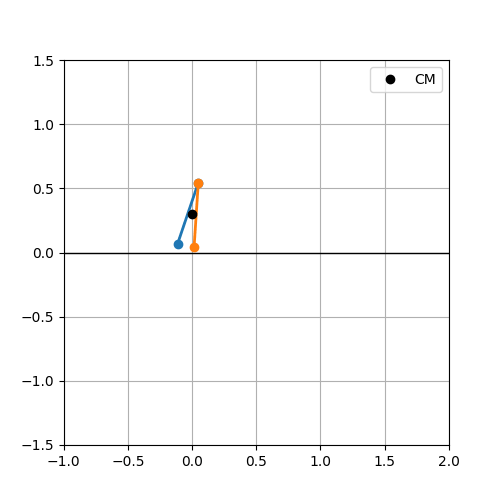

In [134]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# ===============================================
#   2D Animation (saves as GIF and shows inline)
# ===============================================

# --- Forward kinematics (consistent with your dynamics) ---
rCMy, rCMz, qmean, qrel = ca.MX.sym('rCMy'), ca.MX.sym('rCMz'), ca.MX.sym('qmean'), ca.MX.sym('qrel')
q = ca.vertcat(rCMy, rCMz, qmean, qrel)

m, M, l, k, kappa, Jpar, g = ca.MX.sym('m'), ca.MX.sym('M'), ca.MX.sym('l'), ca.MX.sym('k'), ca.MX.sym('kappa'), ca.MX.sym('Jpar'), ca.MX.sym('g')
p = ca.vertcat(m, M, l, k, kappa, Jpar, g)

phi1 = qmean - 0.5*qrel
phi2 = qmean + 0.5*qrel

rBy = rCMy + 2*m*l/(M+2*m)*ca.sin(qmean)*ca.cos(qrel/2)
rBz = rCMz - 2*m*l/(M+2*m)*ca.cos(qmean)*ca.cos(qrel/2)
r1y = rBy - l*ca.sin(phi1)
r1z = rBz + l*ca.cos(phi1)
r2y = rBy - l*ca.sin(phi2)
r2z = rBz + l*ca.cos(phi2)

fk_fun = ca.Function('fk_fun', [q, p], [rBy, rBz, r1y, r1z, r2y, r2z])

# --- Evaluate forward kinematics for each time step ---
YB, ZB, Y1, Z1, Y2, Z2 = [], [], [], [], [], []
for k in range(len(ts)):
    qk = X[k, [0,1,2,3]]   # [rCMy, rCMz, qmean, qrel]
    yb, zb, y1, z1, y2, z2 = fk_fun(qk, p_val)
    YB.append(float(yb)); ZB.append(float(zb))
    Y1.append(float(y1)); Z1.append(float(z1))
    Y2.append(float(y2)); Z2.append(float(z2))

YB, ZB, Y1, Z1, Y2, Z2 = map(np.array, (YB,ZB,Y1,Z1,Y2,Z2))

# --- Setup figure and artists ---
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-1, 2)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True)
ax.axhline(0, color='k', lw=1)

leg1, = ax.plot([], [], 'o-', lw=2, color='tab:blue')
leg2, = ax.plot([], [], 'o-', lw=2, color='tab:orange')
cm_pt, = ax.plot([], [], 'ko', ms=6, label='CM')
contact_dot1, = ax.plot([], [], 'ro', ms=5)
contact_dot2, = ax.plot([], [], 'ro', ms=5)
ax.legend()

# --- Animation init and update functions ---
def init():
    leg1.set_data([], []); leg2.set_data([], [])
    cm_pt.set_data([], []); contact_dot1.set_data([], []); contact_dot2.set_data([], [])
    return leg1, leg2, cm_pt, contact_dot1, contact_dot2

def update(i):
    leg1.set_data([YB[i], Y1[i]], [ZB[i], Z1[i]])
    leg2.set_data([YB[i], Y2[i]], [ZB[i], Z2[i]])
    cm_pt.set_data([float(X[i,0])], [float(X[i,1])])

    if C1[i] > 0.5:
        contact_dot1.set_data([float(Y1[i])], [0.0])
    else:
        contact_dot1.set_data([], [])
    if C2[i] > 0.5:
        contact_dot2.set_data([float(Y2[i])], [0.0])
    else:
        contact_dot2.set_data([], [])
    return leg1, leg2, cm_pt, contact_dot1, contact_dot2

ani = FuncAnimation(fig, update, frames=len(ts),
                    init_func=init, blit=True, interval=dt * 1000, repeat=False)

# --- Save to GIF and display inline ---
gif_path = "motion.gif"
ani.save(gif_path, writer='pillow', fps=int(1/dt))
plt.close(fig)  # avoid duplicate static figure

# Display the animation inline (PyCharm Jupyter)
Image(filename=gif_path)


In [135]:
# phase-1: simulate fall
xk = x0
c1_val, c2_val = 0.0, 0.0

X_fall = [np.array(xk.T).flatten()]  # list of 8-dim states
C1_fall = [c1_val]
C2_fall = [c2_val]
t_fall  = [0.0]

contact_index = None
N_fall = 40

for k in range(N_fall):
    out = f(xk, 0.0, p_val, c1_val, c2_val)
    dxdt_k, lam_k, c1_new, c2_new, dq_plus = out

    dq = xk[4:8]
    if not np.allclose(np.array(dq_plus).flatten(),
                       np.array(dq).flatten(), atol=1e-9):
        xk[4:8] = dq_plus
        contact_index = k
        print(f"Contact at t={k*dt:.3f}s")
        break

    xk = Fstep(xk, 0.0, p_val, c1_val, c2_val)
    c1_val, c2_val = float(c1_new), float(c2_new)

    X_fall.append(np.array(xk.T).flatten())
    C1_fall.append(c1_val)
    C2_fall.append(c2_val)
    t_fall.append((k+1)*dt)

x_contact = xk
c1_contact, c2_contact = c1_val, c2_val

# project onto stance dynamics
x_contact = Fstep(x_contact, 0.0, p_val, c1_contact, c2_contact)

Contact at t=0.100s


In [172]:
# --- Build passive stance trajectory (zero control) as initial guess ---
N2 = 100
X_init = np.zeros((8, N2+1))
X_init[:, 0] = np.array(x_contact).flatten()

u_zero = 0.0
for k in range(N2):
    xk = X_init[:, k]
    x_next = Fstep(xk, u_zero, p_val, c1_contact, c2_contact)
    X_init[:, k+1] = np.array(x_next).flatten()

In [173]:
# ----------------------------
# phase-2 horizon and ref
# ----------------------------
tf2 = 1
dt2 = tf2 / N2
ts2_np = np.linspace(0, tf2, N2+1)
ts2 = ca.DM(ts2_np)

ang_ref2 = ca.DM.zeros(4, N2+1)   # 4 x (N2+1)
ang_ref2[0, :] = np.pi            # qmean = pi, others stay 0

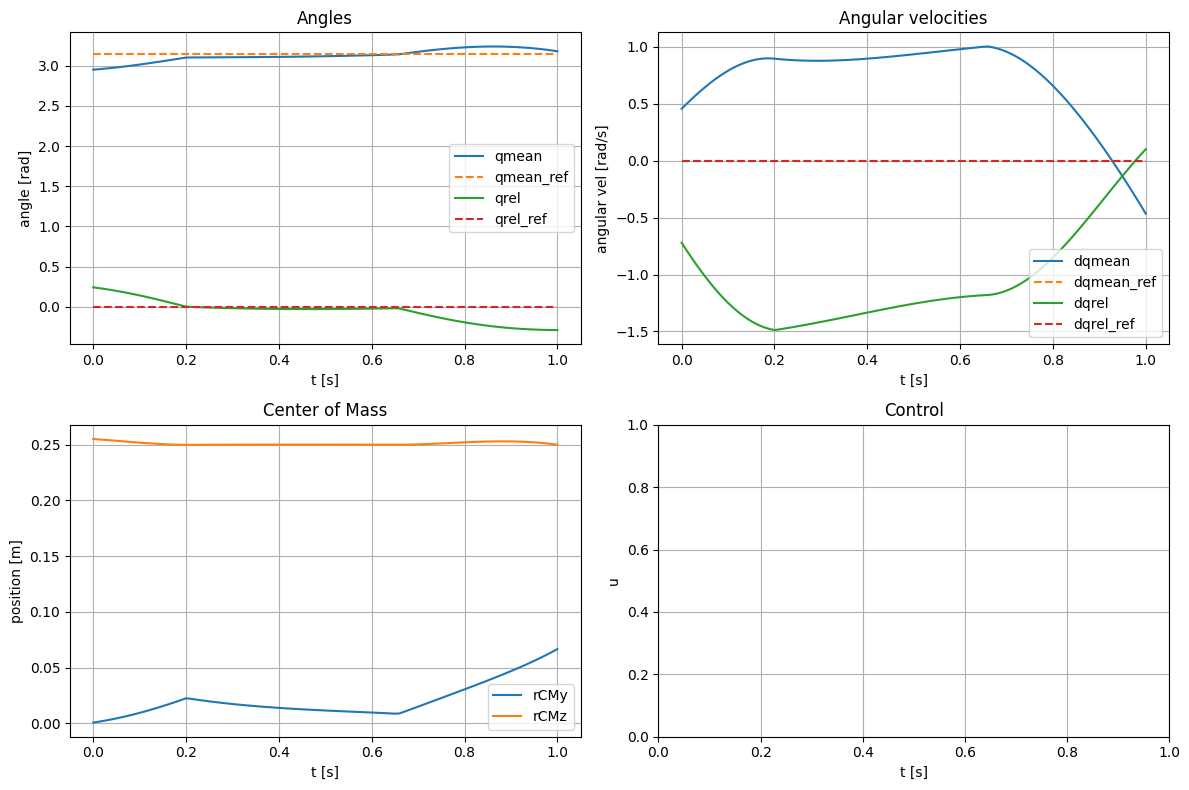

In [174]:
# ----------------------------
# Plot results
# ----------------------------

import matplotlib.pyplot as plt
import numpy as np

# Convert CasADi DMs to numpy
Xn = np.array(X_init)        # shape (8, N2+1)
#Un = np.array(U_opt).reshape(1, -1)  # shape (1, N2)
t2 = ts2_np                 # already np.linspace(0, tf2, N2+1)
tc = ts2_np[:-1]            # control is piecewise-constant per interval

# State components
rCMy  = Xn[0, :]
rCMz  = Xn[1, :]
qmean = Xn[2, :]
qrel  = Xn[3, :]
vCMy  = Xn[4, :]
vCMz  = Xn[5, :]
dqmean = Xn[6, :]
dqrel  = Xn[7, :]

# Reference (already DM 4 x (N2+1))
ang_ref_np = np.array(ang_ref2)   # shape (4, N2+1)
qmean_ref  = ang_ref_np[0, :]
qrel_ref   = ang_ref_np[1, :]
dqmean_ref = ang_ref_np[2, :]
dqrel_ref  = ang_ref_np[3, :]

plt.figure(figsize=(12,8))

# 1) Angles vs ref
plt.subplot(2,2,1)
plt.plot(t2, qmean, label='qmean')
plt.plot(t2, qmean_ref, '--', label='qmean_ref')
plt.plot(t2, qrel, label='qrel')
plt.plot(t2, qrel_ref, '--', label='qrel_ref')
plt.xlabel('t [s]')
plt.ylabel('angle [rad]')
plt.title('Angles')
plt.legend()
plt.grid(True)

# 2) Angular velocities vs ref
plt.subplot(2,2,2)
plt.plot(t2, dqmean, label='dqmean')
plt.plot(t2, dqmean_ref, '--', label='dqmean_ref')
plt.plot(t2, dqrel, label='dqrel')
plt.plot(t2, dqrel_ref, '--', label='dqrel_ref')
plt.xlabel('t [s]')
plt.ylabel('angular vel [rad/s]')
plt.title('Angular velocities')
plt.legend()
plt.grid(True)

# 3) CM position
plt.subplot(2,2,3)
plt.plot(t2, rCMy, label='rCMy')
plt.plot(t2, rCMz, label='rCMz')
plt.xlabel('t [s]')
plt.ylabel('position [m]')
plt.title('Center of Mass')
plt.legend()
plt.grid(True)

# 4) Control
plt.subplot(2,2,4)
#plt.step(tc, Un[0,:], where='post')
plt.xlabel('t [s]')
plt.ylabel('u')
plt.title('Control')
plt.grid(True)

plt.tight_layout()
plt.show()

In [175]:
N2 = 65
tf2 = 1
dt2 = tf2 / N2
ts2_np = np.linspace(0, tf2, N2+1)
ts2 = ca.DM(ts2_np)

ang_ref2 = ca.DM.zeros(4, N2+1)   # 4 x (N2+1)
ang_ref2[0, :] = np.pi            # qmean = pi, others stay 0

# ----------------------------
# Opti for stance phase
# ----------------------------
opti = ca.Opti()

U = opti.variable(1, N2)
X = opti.variable(8, N2+1)

P = opti.parameter(7)
opti.set_value(P, p_val)

# contact flags fixed during this phase
c1_fix = float(c1_contact)
c2_fix = float(c2_contact)

# dynamics constraints with fixed contact
for k in range(N2):
    xk = X[:,k]
    uk = U[:,k]
    x_next = Fstep(xk, uk, P, c1_fix, c2_fix)
    if k == 0:
        opti.subject_to( X[:,k+1] - x_next <= 1e-3 )
        opti.subject_to( X[:,k+1] - x_next >= -1e-3 )
    else:
        opti.subject_to( X[:,k+1] == x_next )

# initial condition = state at contact
opti.subject_to( X[:,0] == x_contact )

alpha = opti.parameter()
opti.set_value(alpha, 1)  # start with the easy target

qmean_easy = np.pi
qrel_easy  = 0.0

qmean_hard = np.pi + np.pi/16
qrel_hard  = -np.pi/12

qmean_target = (1-alpha)*qmean_easy + alpha*qmean_hard
qrel_target  = (1-alpha)*qrel_easy  + alpha*qrel_hard

term_err = ca.vertcat(
    X[2, N2] - qmean_target,
    X[3, N2] - qrel_target,
    X[6, N2],
    X[7, N2]
)

w_term = 1e3   # weight for terminal accuracy (tune)
w_u    = 1   # weight on control effort

opti.minimize( w_u*ca.sumsqr(U) + w_term*ca.sumsqr(term_err) )

# optional terminal conditions and bounds
u_max = 10.0
opti.subject_to( -u_max <= U )
opti.subject_to( U <= u_max )

# Keep CM above ground and not too high
opti.subject_to( X[1, :] >= 0.0 )     # rCMz >= 0
opti.subject_to( X[1, :] <= 2.0 )     # rCMz <= 2 m

#Angles have to invert at least
#opti.subject_to( X[2,N2] > np.pi )
#opti.subject_to( X[3,N2] < 0 )

# Keep angles in a sane range
#opti.subject_to( X[2, :] >= 0.0 )               # qmean in [0, 2π]
#opti.subject_to( X[2, :] <= 2*np.pi )
#opti.subject_to( X[3, :] >= -np.pi )            # qrel in [-π, π]
#opti.subject_to( X[3, :] <=  np.pi )

opti.set_initial(X, X_init)
opti.set_initial(U, 0)

opti.solver(
    'ipopt',
    {
        'expand': True,
        'print_time': True,
    },
    {
        'tol': 1e-5,
        'max_iter': 200,
        'print_level': 5,
        'sb': 'yes',
        "hessian_approximation": "limited-memory"
    }
)

RuntimeError: Error in Opti::set_initial [OptiNode] at .../casadi/core/optistack.cpp:169:
.../casadi/core/matrix_impl.hpp:252: Dimension mismatch. lhs is 8-by-66, while rhs is [8,101]

In [176]:
alphas = [1]
X_guess = ca.repmat(x_contact, 1, N2+1)
U_guess = np.zeros((1, N2))

for a in alphas:
    opti.set_value(alpha, a)
    opti.set_initial(X, X_guess)
    opti.set_initial(U, U_guess)

    sol = opti.solve()
    X_guess = sol.value(X)
    U_guess = sol.value(U)

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1307: Assertion "!solver_name_.empty()" failed:
You must call 'solver' on the Opti stack to select a solver. Suggestion: opti.solver('ipopt')

ValueError: x and y must have same first dimension, but have shapes (11,) and (41,)

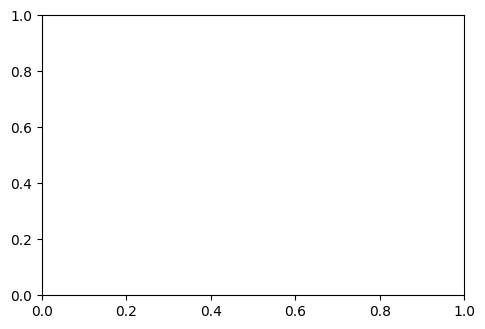

In [147]:
X_opt = X_guess
U_opt = U_guess

# ----------------------------
# Plot results
# ----------------------------

import matplotlib.pyplot as plt
import numpy as np

# Convert CasADi DMs to numpy
Xn = np.array(X_opt)        # shape (8, N2+1)
Un = np.array(U_opt).reshape(1, -1)  # shape (1, N2)
t2 = ts2_np                 # already np.linspace(0, tf2, N2+1)
tc = ts2_np[:-1]            # control is piecewise-constant per interval

# State components
rCMy  = Xn[0, :]
rCMz  = Xn[1, :]
qmean = Xn[2, :]
qrel  = Xn[3, :]
vCMy  = Xn[4, :]
vCMz  = Xn[5, :]
dqmean = Xn[6, :]
dqrel  = Xn[7, :]

# Reference (already DM 4 x (N2+1))
ang_ref_np = np.array(ang_ref2)   # shape (4, N2+1)
qmean_ref  = ang_ref_np[0, :]
qrel_ref   = ang_ref_np[1, :]
dqmean_ref = ang_ref_np[2, :]
dqrel_ref  = ang_ref_np[3, :]

plt.figure(figsize=(12,8))

# 1) Angles vs ref
plt.subplot(2,2,1)
plt.plot(t2, qmean, label='qmean')
plt.plot(t2, qmean_ref, '--', label='qmean_ref')
plt.plot(t2, qrel, label='qrel')
plt.plot(t2, qrel_ref, '--', label='qrel_ref')
plt.xlabel('t [s]')
plt.ylabel('angle [rad]')
plt.title('Angles')
plt.legend()
plt.grid(True)

# 2) Angular velocities vs ref
plt.subplot(2,2,2)
plt.plot(t2, dqmean, label='dqmean')
plt.plot(t2, dqmean_ref, '--', label='dqmean_ref')
plt.plot(t2, dqrel, label='dqrel')
plt.plot(t2, dqrel_ref, '--', label='dqrel_ref')
plt.xlabel('t [s]')
plt.ylabel('angular vel [rad/s]')
plt.title('Angular velocities')
plt.legend()
plt.grid(True)

# 3) CM position
plt.subplot(2,2,3)
plt.plot(t2, rCMy, label='rCMy')
plt.plot(t2, rCMz, label='rCMz')
plt.xlabel('t [s]')
plt.ylabel('position [m]')
plt.title('Center of Mass')
plt.legend()
plt.grid(True)

# 4) Control
plt.subplot(2,2,4)
plt.step(tc, Un[0,:], where='post')
plt.xlabel('t [s]')
plt.ylabel('u')
plt.title('Control')
plt.grid(True)

plt.tight_layout()
plt.show()

In [140]:
# --- concatenate fall + stance ---

X_fall_arr = np.array(X_fall)        # (Nf+1, 8)
X_stance   = np.array(X_opt).T       # (N2+1, 8)

# avoid duplicating the contact state: skip stance[0]
X_full = np.vstack([X_fall_arr, X_stance[1:, :]])   # (N_full, 8)

# contact flags: fall part from sim, stance part constant
C1_stance = np.full(N2+1, c1_contact)
C2_stance = np.full(N2+1, c2_contact)

C1_full = np.hstack([np.array(C1_fall), C1_stance[1:]])
C2_full = np.hstack([np.array(C2_fall), C2_stance[1:]])

# time vector: continue from last fall time
t_fall_arr = np.array(t_fall)
t_stance   = t_fall_arr[-1] + ts2_np  # stance times
ts_full = np.hstack([t_fall_arr, t_stance[1:]])

dt_full = np.median(np.diff(ts_full))  # use for playback speed

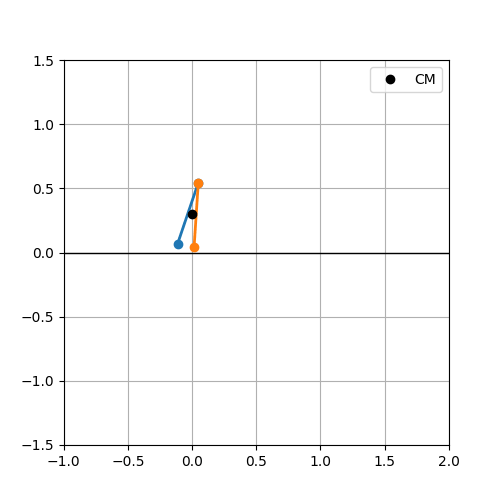

In [141]:
from plotting import visualize

img = visualize(X_full, C1_full, C2_full, ts_full, dt_full, p_val)
img  # in a notebook this will show the GIF